In [84]:
import cv2
import os
from os.path import join as pjoin
import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt

In [85]:
# Содержание
# - Файл simpson-set.tar.gz: Это набор данных изображений: 20 папок (по одной для каждого персонажа) с 400-2000 изображениями в каждой папке.
# - Файл simpson-test-set.zip. : Предварительный просмотр набора данных изображения
# - Файл weights.best.h5 : рассчитанные веса для прогнозирования в ядрах.
# - Файл annotation.txt: файл аннотации для ограничивающих рамок для каждого символа.

In [86]:
# ===========================================
# ===============  Программа  ===============
# ===========================================


# ===================== Констатанты
# папка откуда берем дата сет
SRC_FOLDER_DATA_SET = "data/simpsons_dataset/"
SRC_FOLDER_DATA_SET_TEST_IMAGE = "data/simpsons_dataset/sideshow_bob/pic_0167.jpg"

MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]

CLASSES = ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 
           'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 
           'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 
           'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 
           'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 
           'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']

IS_SHOW_RESULT_TRAIN = 5
IS_SHOW_LOGS = False

In [87]:
# ===================== Конфигурация девайса
# поддержка графического процессора
divice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [88]:
# ===================== Гипер-параметры
EPOCHS = 100
LEARNING_RATE = 0.01
BATCH_SIZE = 4

In [89]:
# ===================== классы
# класс всех с фотками персонажей
class ImagesPerson:
    def __init__(self, link, pos, image, name):
        self.link = link
        self.pos = pos
        self.image = image
        self.name = name

    def __str__(self):
        return f"""{self.name} {self.pos} {self.link}\n{self.image}\n\n"""

In [90]:
# ===================== функции
# получить подготовленную картинку
def get_normalize_image(src, path_pos):
    image = cv2.imread(src)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # берем часть изображения предоставленную из файла
    # image = cv2.resize(image, dsize=(150, 150))
    # image = image[path_pos[0]:path_pos[2], path_pos[1]:path_pos[3]]
    # нормализация изображения что бы было с 0 до 255 на от 0 до 1, что бы нейронке было проще
    image = image / 255
    
    
    # # Обработка входного изображения:
    # transform = torchvision.transforms.Compose([
    #     torchvision.transforms.ToTensor(),
    #     torchvision.transforms.Normalize(
    #         mean=[0.5],
    #         std=[0.5],
    #     ),
    # ])
    # scripted_transforms = torch.jit.script(transforms)

    return image

# считать изображения для дата сета full
def get_full_data_set():
    df = pd.read_csv('./data/annotation.txt', header=None, sep=",")
    # print(df.head())
    list_person: ImagesPerson = []
    print("начал считывать данные")
    for item in tqdm.tqdm(df.itertuples()):
        file = os.path.join(SRC_FOLDER_DATA_SET, item[1].replace('./characters/', ''))
        if os.path.isfile(file):
            image = get_normalize_image(file, tuple(item[2:6]))
            list_person.append(ImagesPerson(item[1], tuple(item[2:6]), image, item[6]))
    print("данные сохранены")
    if (IS_SHOW_LOGS): 
        print(*list_person[:5])
    return list_person

# отображение изображений
def print_result_sep_data(data):
    plt.figure(figsize=(10, 10))
    for item in range(IS_SHOW_RESULT_TRAIN * 5):
        if (IS_SHOW_LOGS): 
            print(train_dataset[0])
        plt.subplot(5, IS_SHOW_RESULT_TRAIN, item + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(train_dataset[item].image, cmap=plt.cm.binary)
        plt.xlabel([train_dataset[item].name])
        # plt.grid(False)
    plt.show()
  

начал считывать данные


6752it [00:30, 223.93it/s]


данные сохранены


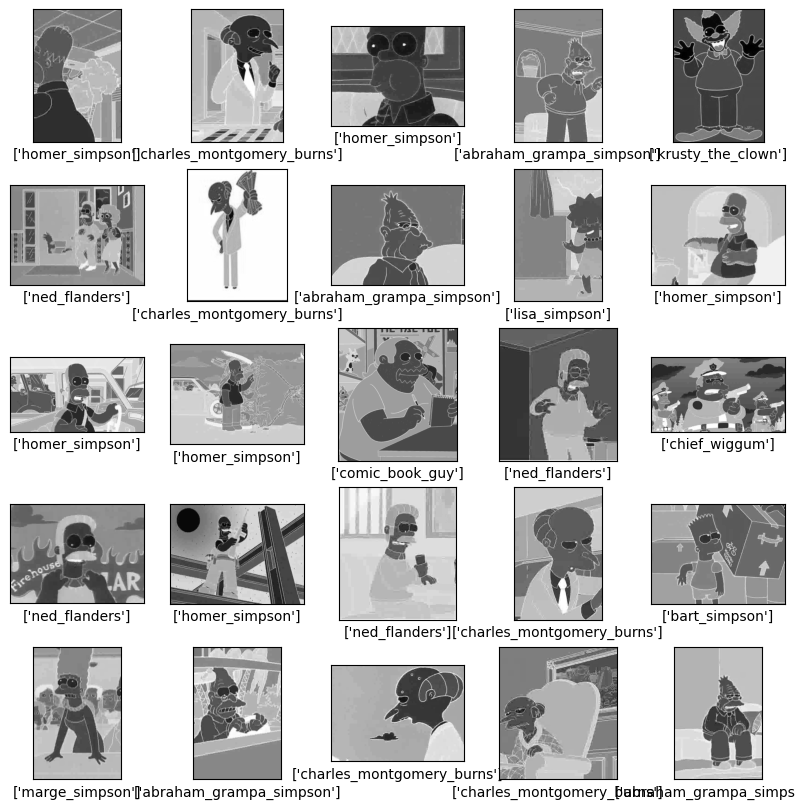

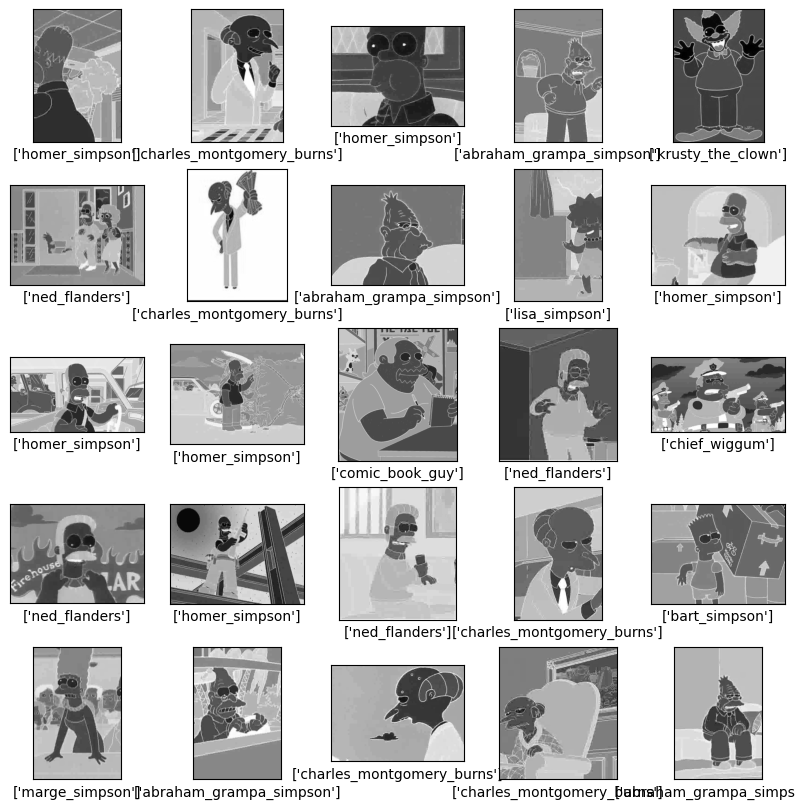

In [91]:
# ===================== CODE
full_data = get_full_data_set()
train_dataset, test_dataset = torch.utils.data.random_split(full_data, [0.7, 0.3])

# смотрим что получаем
print_result_sep_data(train_dataset)
print_result_sep_data(test_dataset)

# Модель
in_ch = 64
out_ch = 10

model = nn.Sequential(
    nn.Linear(in_ch, 32),
    nn.ReLU(),
    nn.Linear(32, out_ch, bias=False),
    nn.ReLU(),
)

In [92]:
# Обучение
# model.forward()

# Обработка входного изображения:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(MEAN_IMAGE_TRANSFORM), torch.Tensor(MEAN_IMAGE_STD))
])

train_dataset = torchvision.datasets.ImageNet(root=SRC_FOLDER_DATA_SET_TEST_IMAGE, transform=transform_image)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)

batch, _ = next(iter(train_dataloader))

print(batch.shape)

figure = plt.figure(figsize=(10, 10))
# plt.subplot(3, 3, 1)
# plt.tight_layout()
plt.imshow(batch[0][0], cmap='gray', interpolation='none')

# train_dataset = torchvision.datasets.ImageFolder(root="data/simpsons_dataset", transform=transform_image)

# train_dataloader = torch.utils.data.DataLoader(
#     dataset=train_dataset,
#     batch_size=32,
#     shuffle=True,
#     num_workers=4,
# )


# batch, _ = next(iter(train_dataloader))

# print(batch.shape)

# figure = plt.figure(figsize=(10, 10))

# for index in range(9):
#     plt.subplot(3, 3, index + 1)
#     plt.tight_layout()
#     plt.imshow(batch[index][0], cmap='gray', interpolation='none')


# Результат

ModuleNotFoundError: No module named 'scipy'